In [1]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [17]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/"
path = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/'
SRS_gain = 100 # gain on the SRS bandpass filter
peak_threshold = 700 # upper bound of pedestal
breakdown = 27.4 # breakdown voltage of the SiPM
pedestal = 275 # center of noise pedestal peak

file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 20 files


In [3]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [4]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [14]:
def find_peaks_and_fit(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, peak_range=500):
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    
    peaks_index, _ = scipy.signal.find_peaks(y_data, distance=min_distance)
    
    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    gain_info = [] # parameters to fit the gain
    peak_params = [] # parameters to plot the gaussian
    peak_number = 1 # corresponds to single photoelectron peak
    peaks = [] # list of where all the peaks are that are used in the fits
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue
        
        peaks.append(np.array([x_data[peak], y_data[peak]]))
        
        # initial guess for the Gaussian parameters
        amplitude_guess = y_data[peak]
        mean_guess = x_data[peak]
        standard_deviation_guess = 50
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # cutting data around each peak
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - 200))
        else:
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - peak_range))
        peak_x = x_data[cut] # x values of peak for fitting
        peak_y = y_data[cut] # y values of peak for fitting
        
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            # params are returned as amplitude, mean, std dev
#             print('Guess: ', initial_guess)
#             print('Params: ', params)
            peak_params.append(params)
            gain_info.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            peak_params.append(initial_guess)
            gain_info.append([peak_number, mean_guess, np.nan])
#             xx = np.linspace( x_data[peak] - 2*standard_deviation_guess, x_data[peak] + 2*standard_deviation_guess, 100 )
        
#         gain_info.append([peak_number, params[1], np.sqrt(params_covariance[1,1])]) # peak number, mean, and covariance
        peak_number += 1 # (goes to n*spe until it reaches max_peak)
        print(peak_number)
    plt.show()
    return np.array(peak_params), np.array(gain_info), np.array(peaks)

In [6]:
def gain_fit(pe_locations):
    fpts = ~np.isnan(pe_locations[:,1])
    if(np.sum(fpts) < 3):
        return
    # fitting the peak locations to a line to find the gain (slope)
    gain_bp, gain_bc = curve_fit(lin_fun, pe_locations[fpts, 0], pe_locations[fpts, 1])

    x = pe_locations[fpts, 0]
    
    return x, gain_bp, gain_bc

def find_bv(g_vs_v, wavelength):
    # finding the breakdown voltage using fitted gain data of a certain wavelength (310, 405, or source)
    data_to_use = np.asarray(g_vs_v[wavelength])
    
    # fitting the curve 
    bv_params, bv_cov = curve_fit(lin_fun, data_to_use[:, 0], data_to_use[:, 1], sigma=data_to_use[:, 2])
    
    return bv_params, bv_cov

Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_33.90OV_405_0.h5
Distance:  40
2
3
4
5
6
[  91.82979894 1114.83995374   58.91780675]
[  72.43078428 2187.24617978   61.1647453 ]
[  58.48806532 3262.61449724   62.71839622]
[  40.90510008 4334.33944846   87.69435695]
[  30.18727389 5401.58811415  116.31595347]


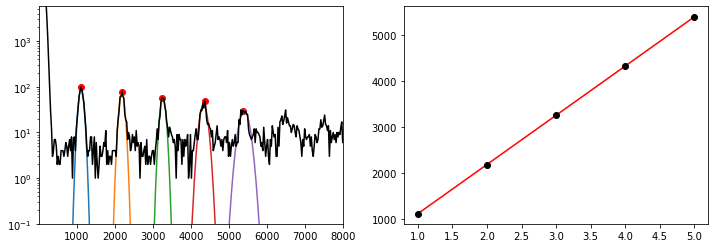

Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_33.90OV_310_0.h5
Distance:  40
2
3
4
5
6
[ 118.53758927 1117.05278646   59.08891459]
[  83.91643894 2186.57296939   62.7477989 ]
[  65.20683137 3246.23754002   64.67003466]
[  37.27354637 4327.42247383  114.89377969]
[  22.3253221  5412.95201184  228.95044444]


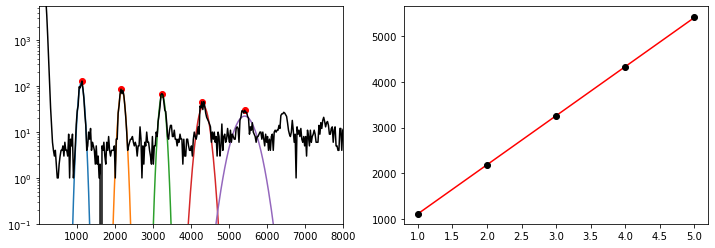

Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_33.40OV_405_0.h5
Distance:  35
2
3
4
5
6
[ 110.92468217 1032.31291337   54.6081706 ]
[  77.94977017 2028.20931745   56.406507  ]
[  73.09400124 3023.87361993   58.55621071]
[  56.69288738 4029.18898279   73.63806156]
[  43.93080905 5020.01248447   78.78331498]


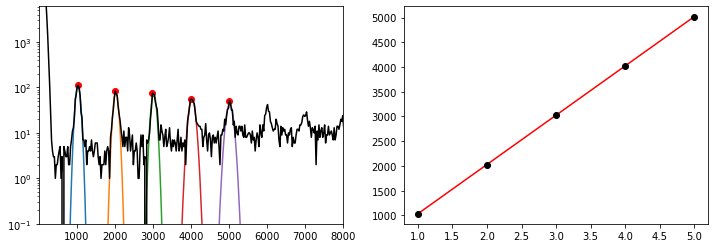

Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_33.40OV_310_0.h5
Distance:  35
2
3
4
5
6
[ 142.69945219 1038.82960374   51.37191399]
[  98.12320088 2028.46718596   57.17670383]
[  68.31211705 3019.5649378    75.09860602]
[  55.34469911 4002.48581791   76.89771043]
[  32.29995054 4998.94911579  141.83769541]


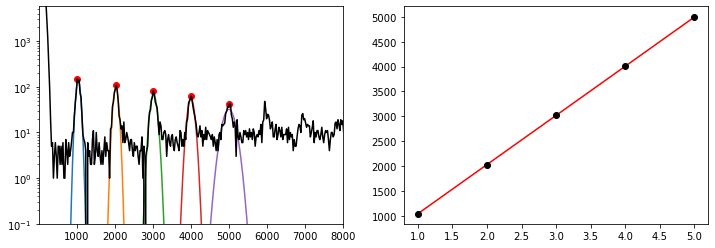

Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_32.90OV_405_0.h5
Distance:  30
2
3
4
5
6
[103.96373972 960.15401239  57.54299715]
[  92.70732992 1877.90270787   57.15625966]
[  82.26744331 2789.47541561   57.18688465]
[  70.10470077 3705.84248148   69.14065951]
[  51.33895063 4606.63055207   82.16395338]


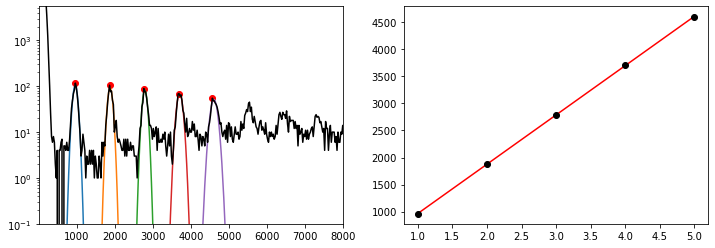

Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_32.90OV_310_0.h5
Distance:  30
2
3
4
5
6
[148.610073   956.23504345  52.38026569]
[ 121.466117   1868.50402471   53.68105514]
[  84.28830291 2780.88708489   66.10295983]
[  63.30091331 3698.73696094   85.04694191]
[  44.53187663 4600.59968046  110.30733691]


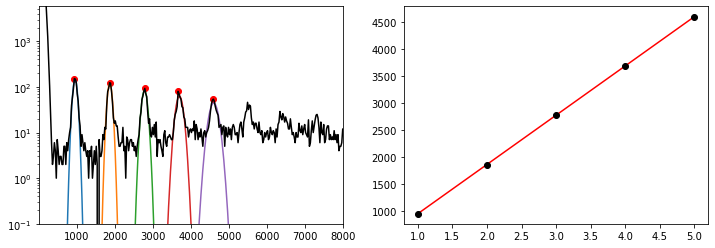

Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_32.40OV_405_0.h5
Distance:  25
2
3
4
5
6
[114.62447126 878.17434402  51.96996741]
[ 108.24356893 1711.9022386    56.90746044]
[  98.85957325 2549.72453426   57.69116508]
[  73.97619567 3391.08007941   81.02255306]
[  65.55886423 4221.8169111    75.83858125]


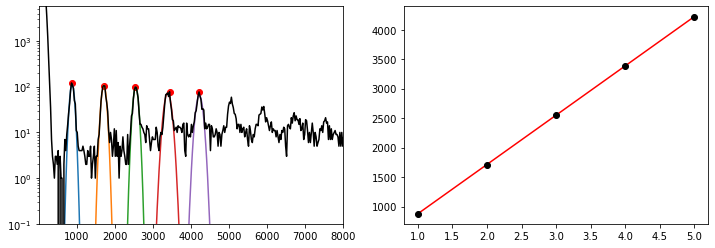

Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_32.40OV_310_0.h5
Distance:  25
2
3
4
5
6
[158.08830325 877.24756085  53.93081371]
[ 134.89366498 1707.51307699   58.98187671]
[ 123.13053744 2546.57513311   60.48407142]
[ 101.55517929 3371.21886046   63.99183262]
[  57.33718274 4205.52015743   94.55304403]


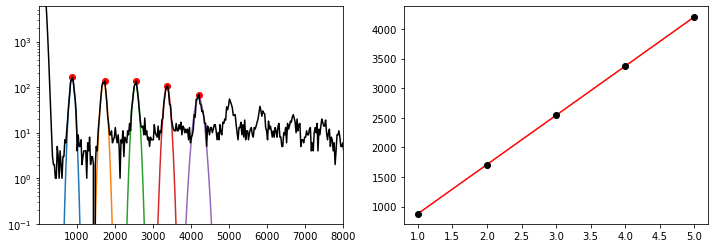

Working on file #8: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_31.90OV_405_0.h5
Distance:  25
2
3
4
5
6
[126.5793478  800.42486774  53.34684684]
[ 129.41457197 1556.84206631   56.1304066 ]
[ 133.75210536 2308.37608158   56.30122053]
[ 107.14679243 3064.49699425   60.53837778]
[  78.42331981 3811.72032397   75.09126546]


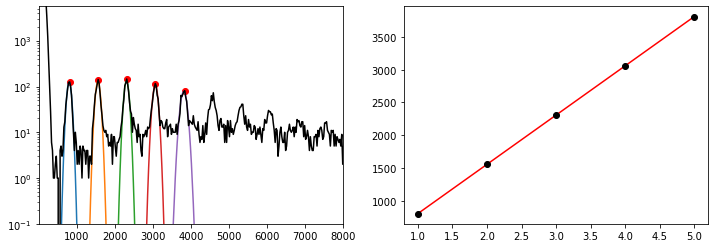

Working on file #9: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_31.90OV_310_0.h5
Distance:  25
2
3
4
5
6
[167.23875902 795.14406078  55.11398288]
[ 177.2707492  1546.4821529    54.16548068]
[ 133.36693127 2300.16144736   64.51563355]
[  93.8330156  3051.19406004   73.97856787]
[  68.52990779 3797.54463086   87.98346809]


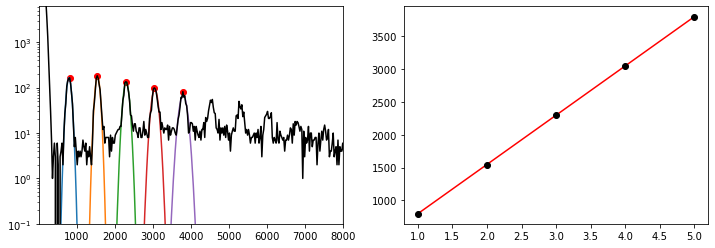

Working on file #10: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_31.40OV_405_0.h5
Distance:  25
2
3
4
5
6
[148.2995808  711.67793588  51.74884245]
[ 153.63515577 1388.43721496   53.60787935]
[ 152.13217472 2059.58971358   57.94813082]
[ 119.25447932 2731.98507724   61.60998236]
[  91.94848586 3405.43734746   70.98922354]


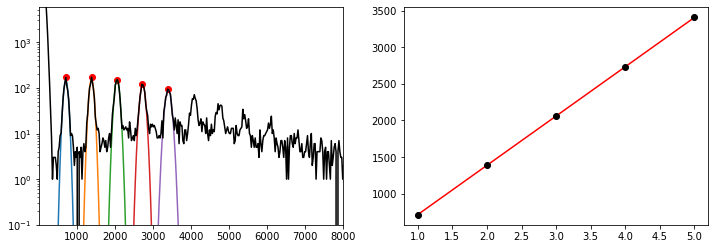

Working on file #11: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_31.40OV_310_0.h5
Distance:  25
2
3
4
5
6
[178.80422855 711.38716722  53.8392414 ]
[ 181.93087413 1383.20350197   55.0099393 ]
[ 167.37187164 2052.66236867   54.20843107]
[ 123.4651487  2723.69190625   65.07712056]
[  81.16439876 3383.278797     76.72419744]


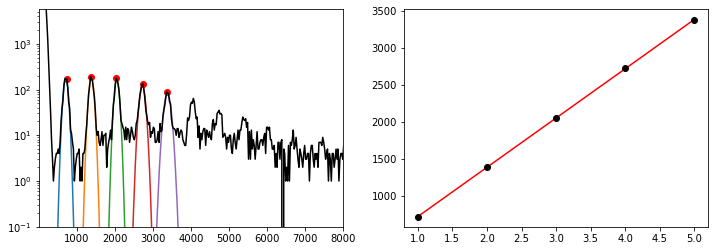

Working on file #12: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_30.90OV_405_0.h5
Distance:  20
2
3
4
5
6
[168.86788543 630.54465949  51.2634876 ]
[ 196.27167732 1221.90663642   53.43582334]
[ 174.29445833 1814.14162113   59.4447564 ]
[ 140.02514254 2400.56293908   66.34370367]
[  93.03279636 2985.85772159   70.86617737]


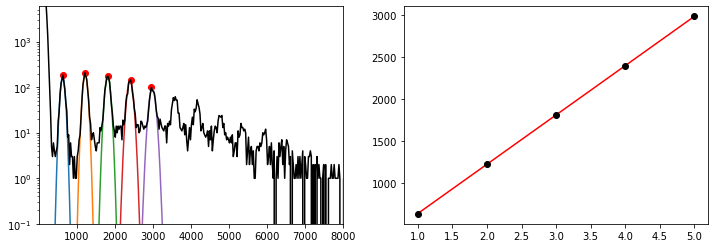

Working on file #13: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_30.90OV_310_0.h5
Distance:  20
2
3
4
5
6
[207.09920559 628.63603626  53.15669369]
[ 219.35666091 1214.27985108   54.43913051]
[ 181.4905964  1803.04608056   58.1560136 ]
[ 137.38608282 2386.84053169   62.67310368]
[  92.59858413 2974.41671122   67.56144701]


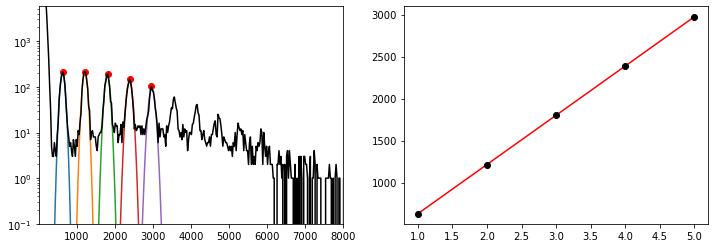

Working on file #14: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_30.40OV_405_0.h5
Distance:  15
2
3
4
5
6
[206.68761157 545.36515884  52.31321338]
[ 220.85621612 1053.30046289   54.58599287]
[ 207.81777782 1564.45571375   55.8795847 ]
[ 163.50098306 2065.61405733   58.03201937]
[ 109.35237622 2578.63533872   66.08245848]


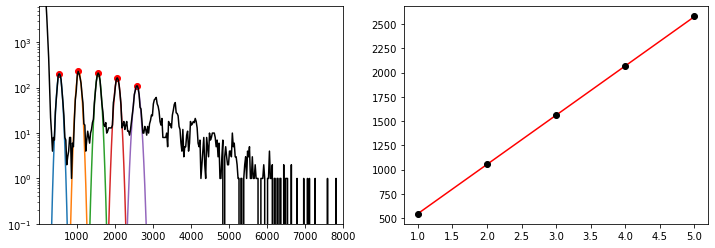

Working on file #15: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_30.40OV_310_0.h5
Distance:  15
2
3
4
5
6
[234.5082528  545.54222428  50.85769672]
[ 250.51602596 1051.55464609   51.81347669]
[ 199.38005646 1554.29557178   59.11055194]
[ 133.7025919  2061.2342627    63.33768931]
[  83.61422808 2557.67698365   71.38415848]


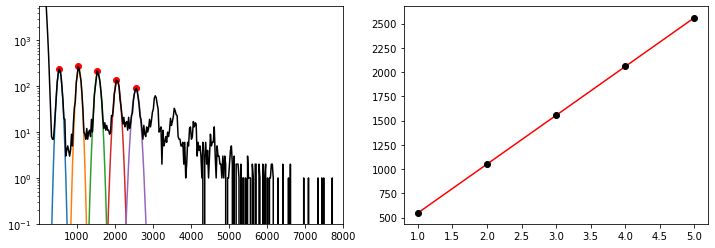

Working on file #16: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_29.90OV_405_0.h5
Distance:  15
2
3
4
5
6
[237.88498996 458.37579198  55.71105641]
[293.97042725 885.87928697  52.97676562]
[ 233.43871102 1307.70140361   55.64182058]
[ 161.43685322 1732.0210148    60.12724888]
[ 103.17955463 2154.63696796   60.72603305]


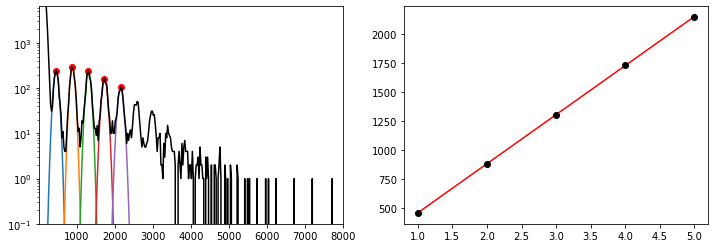

Working on file #17: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_29.90OV_310_0.h5
Distance:  15
2
3
4
5
6
[249.35901096 458.65224835  56.43583443]
[272.28082809 878.89597074  52.04338761]
[ 221.90229231 1299.28787982   54.31553655]
[ 145.26824932 1723.316266     56.67631038]
[  83.77841043 2134.57487931   60.14236145]


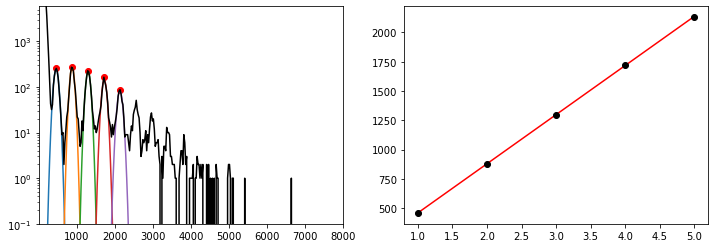

Working on file #18: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_29.40OV_405_0.h5
Distance:  10
fit failed
2
3
4
5
6
[289.         387.68931298  50.        ]
[301.02398822 714.70836063  54.0625252 ]
[ 230.36956661 1054.67124825   55.46139208]
[ 142.77681241 1389.86843789   53.80865759]
[  75.90643575 1723.91355502   58.17514977]


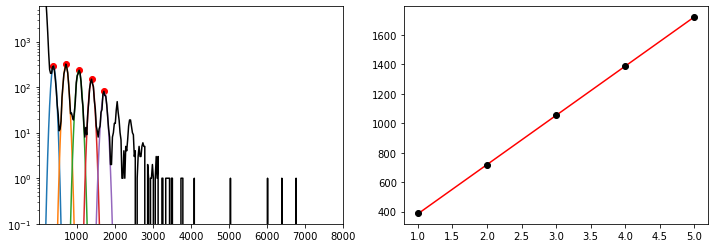

Working on file #19: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step14/mca_keith_29.40OV_310_0.h5
Distance:  10
fit failed
2
3
4
5
6
[293.         387.68931298  50.        ]
[297.40532977 713.85759269  53.52035027]
[ 214.42644717 1048.30716122   55.21822595]
[ 126.08848572 1382.69086889   60.23028914]
[  57.11014603 1717.92473999   70.12971786]


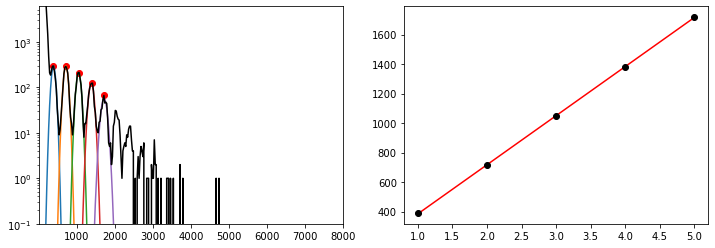

In [18]:
guess_1pe = 1100 * SRS_gain/100 - pedestal ## based on highest gain data
guess_sig = 0.1

source_distances = [40, 35, 30, 25, 25, 25, 20, 15, 15, 15] # distances are with respect to bin size of 25
LED_distances = [40, 40, 35, 35, 30, 30, 25, 25, 25, 25, 25, 25, 20, 20, 15, 15, 15, 15, 15-5, 15-5]
LED_and_source_distances = (LED_distances+source_distances)
LED_and_source_distances.sort(reverse=True)

gain_vs_volts = {}
for i,(file, dist) in enumerate(zip(file_list, LED_distances)): 
    print("Working on file #%d: %s"%(i,file))
    print('Distance: ', dist)

    file_parts = file.split("_")
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data

    # finding the section of the data around the given peak
    if file_wavelength == 405.:
        peak_range = 150 # picking a smaller range of values to fit the 405 data
    elif file_volts < 30:
        peak_range = 150 # picking a smaller range of values to fit over for the lower OV files
    else:
        peak_range = 500
    
    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, 25)
#     peak_info, pe_locs, peaks = find_peaks_and_fit(b, c, file_volts, min_distance=dist)
    
    # getting the peak and fit info
    if (file_wavelength != 'source') & (file_volts < 32): # if low OV data, first PE peak is a little lower
        peak_info, pe_locs, peaks = find_peaks_and_fit(b, c, file_volts, min_distance=dist, min_thresh=5, peak_range=peak_range)
    
    else:
        peak_info, pe_locs, peaks = find_peaks_and_fit(b, c, file_volts, min_distance=dist, peak_range=peak_range)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(peaks[:,0], peaks[:,1], 'o', color='r')
    
    for fit_params in peak_info:
        print(fit_params)
        plt.plot(b, gauss_fun(b, *fit_params))
    
#     plt.scatter(b, c, marker='.')
#     plt.plot(b, c, 'k')
#     plt.ylim(0.1, 350)
    plt.semilogy(b, c, 'k')
    plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 8000)
    
#     plt.xlim(0, guess_1pe*6)

### don't think that we are using this
#     if(len(gain_vs_volts) > 0):
#         guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    plt.subplot(1,2,2)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    xx, gain_params, gain_cov = gain_fit(pe_locs)
    plt.plot( xx, lin_fun(xx, *gain_params), 'r')
    
    if file_wavelength not in gain_vs_volts:
        gain_vs_volts[file_wavelength] = [np.array([file_volts, gain_params[0], np.sqrt(gain_cov[0,0])])]
        
    else:
        gain_vs_volts[file_wavelength].append(np.array([file_volts, gain_params[0], np.sqrt(gain_cov[0,0])]))

    plt.show()

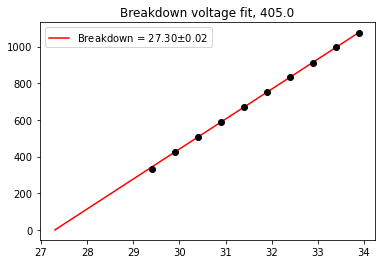

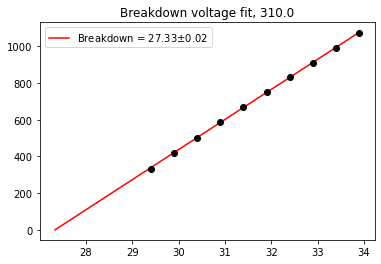

In [19]:
##### print(gain_vs_volts) ## 2nd array - last value looks WAY off
wavelengths = [405.0, 310.0]
# gain_vs_volts[wavelengths] = np.asarray(gain_vs_volts[wavelengths])

for wl in wavelengths:
    breakdown, break_cov = find_bv(gain_vs_volts, wl)
    
    bv_data = np.asarray(gain_vs_volts[wl])
    plt.figure()
    plt.errorbar(bv_data[:,0], bv_data[:,1], yerr=bv_data[:,2], fmt='ko')
    x_bv = np.linspace(breakdown[1], np.max(bv_data[:,0]), 100)
    plt.plot(x_bv, lin_fun(x_bv,*breakdown), 'r', label="Breakdown = %.2f$\pm$%.2f"%(breakdown[1], np.sqrt(break_cov[1,1])))
    plt.title("Breakdown voltage fit, {}".format(wl))
    plt.legend()
    plt.show()
    
# wl_to_use = gain_vs_volts[:,3] == 405 ###### was this only to select 405 nm data?
# print(wl_to_use)
# print(np.array(gain_vs_volts[wl_to_use,:]))

In [14]:
## Plot latest file

# path = r"C:/Data/20230213/Step16/"

type_list = [405.0, 310.0]
col_list = ['k', 'b', 'purple']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(20,4))
fig2 = plt.figure(figsize=(6,4))
for j,t in enumerate(type_list):
    file_list = natsort.realsorted(glob.glob(path + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))


    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 1)

        if(len(norm_range)==2):
            gpts = (b < norm_range[1]) & (b > norm_range[0])
            norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        plt.semilogy(b, c/norm_fac, color=col_list[j])
        plt.ylim(1e-3,1e-1)
        plt.xlim(0,1000)

        plt.figure(fig2.number)
        plt.plot(b, c/norm_fac - ref_hist, color=col_list[j])
        plt.ylim(0,1)
        plt.xlim(0,4000)

plt.show()

Found 0 files
Found 0 files


<Figure size 1440x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>